In [1]:
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
time_series_df =pd.read_csv('ETL_Stats_PosCheck.csv')
time_series_df.head()

,business_start_date,business_end_date,job_name,client_name,no_of_records_in_received,no_of_records_processed
0,2018-09-06,2018-09-06,PosCheckSTG,texasroadhouse,135925,135925
1,2018-09-07,2018-09-08,PosCheckSTG,texasroadhouse,544809,544809
2,2018-09-09,2018-09-09,PosCheckSTG,texasroadhouse,236840,236840
3,2018-09-10,2018-09-11,PosCheckSTG,texasroadhouse,241280,241280
4,2018-09-12,2018-09-13,PosCheckSTG,texasroadhouse,290354,290354


In [3]:
time_series_df.rename(index=str, columns={"business_start_date": "load_date", "no_of_records_in_received": "actuals"}, inplace = True)
time_series_df = time_series_df[["load_date","actuals"]]

In [4]:
time_series_df.head()

,load_date,actuals
0,2018-09-06,135925
1,2018-09-07,544809
2,2018-09-09,236840
3,2018-09-10,241280
4,2018-09-12,290354


In [5]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 0 to 240
Data columns (total 2 columns):
load_date    241 non-null object
actuals      241 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


In [6]:
time_series_df.load_date = pd.to_datetime(time_series_df.load_date, format='%Y-%m-%d')

In [7]:
time_series_df.head()

,load_date,actuals
0,2018-09-06,135925
1,2018-09-07,544809
2,2018-09-09,236840
3,2018-09-10,241280
4,2018-09-12,290354


The order of data here is important and should be **chronological** as we are going to forecast the next point.

In [9]:
time_series_df = time_series_df.sort_values(by="load_date")

In [10]:
time_series_df = time_series_df.reset_index(drop=True)
time_series_df.head()

,load_date,actuals
0,2018-09-06,135925
1,2018-09-07,544809
2,2018-09-09,236840
3,2018-09-10,241280
4,2018-09-12,290354


In [11]:
len(time_series_df)

241

# Decomposing Time Series

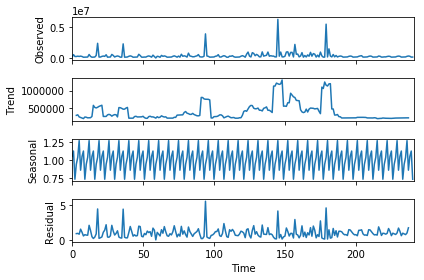

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_decompse = seasonal_decompose( np.array(time_series_df['actuals']),model='multiplicative',freq = 7 )
## Plotting the deocompsed time series components
ts_plot = ts_decompse.plot()

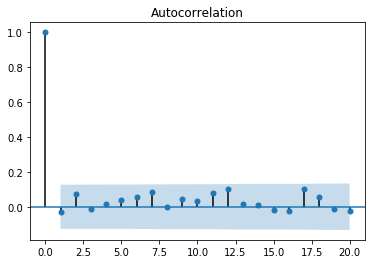

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Show autocorrelation upto lag 10
acf_plot = plot_acf( time_series_df.actuals,lags=20)

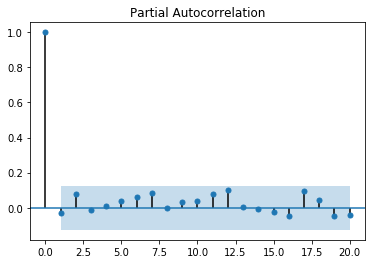

In [14]:
pacf_plot = plot_pacf( time_series_df.actuals,lags=20 )

In [15]:
time_series_df.set_index( pd.to_datetime(time_series_df.load_date), inplace= True)
time_series_df.drop('load_date', axis = 1, inplace = True)

In [16]:
time_series_df

,actuals
load_date,
2018-09-06,135925
2018-09-07,544809
2018-09-09,236840
2018-09-10,241280
2018-09-12,290354
2018-09-14,248591
2018-09-15,297511
2018-09-16,243766
2018-09-17,121828


# Dicky-Fuller Test

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adfuller_test( ts, info_criteria ):
    adfuller_result = adfuller( ts, regression= 'ctt' ,autolag=info_criteria )
    adfuller_out = pd.Series(adfuller_result[0:4],
    index=['Test Statistic',
    'p-value',
    'Lags Used',
    'Number of Observations Used'])
    print( adfuller_out )

In [19]:
adfuller_test(time_series_df.actuals, info_criteria = None)

Test Statistic                  -3.276084
p-value                          0.180572
Lags Used                       15.000000
Number of Observations Used    225.000000
dtype: float64


Inference:
    1. It is quadratic trend

In [20]:
adfuller_test(time_series_df.actuals, info_criteria = 'AIC')

Test Statistic                -1.614296e+01
p-value                        1.204011e-24
Lags Used                      0.000000e+00
Number of Observations Used    2.400000e+02
dtype: float64


In [21]:
adfuller_test(time_series_df.actuals, info_criteria = 'BIC')

Test Statistic                -1.614296e+01
p-value                        1.204011e-24
Lags Used                      0.000000e+00
Number of Observations Used    2.400000e+02
dtype: float64


Extract the values and apply log transform to stabilize the variance in the data or to make it stationary before feeding it to the model.(If needed)

Divide the data to train and test with 70 pct in train data

In [22]:
train = time_series_df.actuals[:int(0.7*(len(time_series_df)))]#70 pct data
test = time_series_df.actuals[int(0.7*(len(time_series_df))):]#30 pct data

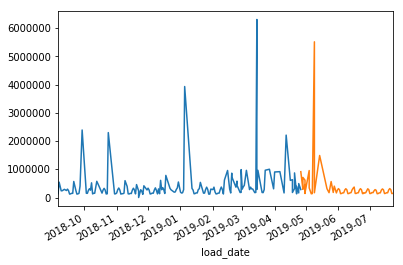

In [23]:
train.plot()
test.plot()

The parameter we specified here seems to work well for the metric but it would be an exhaustive task to do the plots verify and tune the parameters. A solution to this is Auto Arima which returns the best set of parameters for the algorithm in our specified range.

In [24]:
from pmdarima import auto_arima

In [32]:
warnings.filterwarnings('ignore')
stepwise_model = auto_arima(train,
                            start_p=0, d=None, start_q=0, 
                            max_p=7, max_d=7, max_q=7, 
                            start_P=0, D=None, start_Q=0, 
                            max_P=7, max_D=7, max_Q=7, 
                            max_order=None, 
                            m=52, 
                            seasonal=True, stationary=False, 
                            information_criterion='aic', 
                            alpha=0.05, test='kpss', 
                            seasonal_test='ch', 
                            stepwise=True, n_jobs=-1, start_params=None, transparams=True, method=None, trend='c', 
                            solver='lbfgs', maxiter=50, 
                            disp=0, callback=None, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='warn', trace=True, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse')

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 2, 0, 52); AIC=1989.642, BIC=1993.960, Fit time=0.814 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 2, 0, 52); AIC=1960.258, BIC=1968.893, Fit time=8.714 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 2, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 2, 0, 52); AIC=1978.487, BIC=1984.964, Fit time=2.023 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 2, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 2, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 2, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 2, 0, 52); AIC=1968.905, BIC=1975.381, Fit time=6.735 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 2, 0, 52); AIC=1961.434, BIC=1972.229, Fit time=10.765 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 2, 0, 52); AIC=1964.116, BIC=

In [33]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(1, 0, 0)x(1, 2, 0, 52)   Log Likelihood                -976.129
Date:                            Sat, 31 Aug 2019   AIC                           1960.258
Time:                                    22:25:08   BIC                           1968.893
Sample:                                         0   HQIC                          1963.660
                                            - 168                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.769e+05   1.86e+05      1.492      0.136   -8.68e+04    6.41e+05
ar.L1         -0.4469      0.083     -5.384      0.000      -0.610      -0.284
ar.S.L52      -0.6273      0.133     -4.724      0.000      -0.888      -0.367
sigma2      1.443e+12      0.166    8.7e+12      0.000    1.44e+12    1.44e+12
===================================================================================
Ljung-Box (Q):                       18.42   Jarque-Bera (JB):              1061.53
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             3.15
Prob(H) (two-sided):                  0.22   Kurtosis:                        21.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+28. Standard errors may be unstable.
"""

In [34]:
predicted = stepwise_model.predict(n_periods= len(test))
predicted

array([  130805.99588228,   311178.1040075 ,   406939.96680743,
         526756.75096164,   642985.44234343,   366072.05186013,
       -1099931.59890633,  1014389.07388575,  1501649.4676005 ,
         508119.60314324,   249740.50873003,  1290882.86638768,
         914582.81885947,   769074.47114069,   965425.08524712,
         780373.66687411,   147073.23486202,   220153.27125829,
        1651342.14493242,   515789.32600318,   575073.00695568,
         664510.47024647,  1485071.06993338,   566830.38260717,
        -661041.70307871,   668180.5399758 ,   575482.56890175,
         369321.72294311,   308884.33426699,  8712271.94507291,
        1417593.2347538 ,  1520132.21570419,   418864.74369891,
         379242.46563784,   516688.4264946 ,  1185716.7963455 ,
        1360422.89167643,   603452.69535162,  1434079.02395169,
        1493107.52326376,   365420.59778804,  3101809.53379623,
         888848.05134167,   987804.82350587,   428337.71241684,
         372332.55223584,  1273976.19405

# Calculating forecast accuracy

### Mean Absolute Pct Error

In [35]:
def get_mape(actual, predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.round( np.mean(np.abs((actual - predicted) / actual)) * 100, 2 )
get_mape(test, predicted)

374.94

### Root Mean Square error

In [36]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error( test, predicted)))#Actual , predicted

1402962.3597926013


In [37]:
predicted_df=pd.DataFrame()
predicted_df['load_date']= time_series_df.index[int(0.7*(len(time_series_df))):]
predicted_df['actuals']= list(time_series_df.actuals[int(0.7*(len(time_series_df))):])
predicted_df['predicted']= predicted

predicted_df

,load_date,actuals,predicted
0,2019-04-26,915329,1.308060e+05
1,2019-04-28,290060,3.111781e+05
2,2019-04-28,712701,4.069400e+05
3,2019-04-30,615351,5.267568e+05
4,2019-04-30,144733,6.429854e+05
5,2019-04-30,457825,3.660721e+05
6,2019-04-30,167076,-1.099932e+06
7,2019-05-04,955462,1.014389e+06
8,2019-05-04,342533,1.501649e+06
9,2019-05-06,131884,5.081196e+05


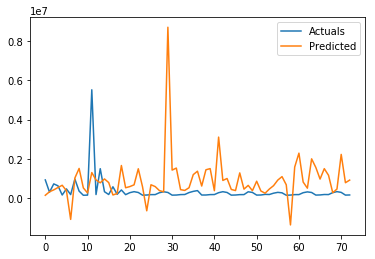

In [38]:
#plot the predictions for test set
plt.plot(predicted_df.actuals, label='Actuals')
plt.plot(predicted_df.predicted, label='Predicted')
plt.gca().legend(('Actuals','Predicted'))
plt.show()

We have results of forecast and actuals, to detect anomalies using this information, We will use the property of the distribution of data for this purpose

Steps to detect anomalies:
1. Compute the error term(actual- predicted).
2. Compute the rolling mean and rolling standard deviation(window is a week).
3. Classify data with an error of 1.5,1.75 and 2 standard deviations as limits for low,medium and high anomalies. (5% of data point would be identified anomalies based on this property)

Error range: 87% [LOW], 92% [MEDIUM], 95% [HIGH]

https://en.wikipedia.org/wiki/Probit
https://measuringu.com/pcalcz/

In [39]:
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['mean_val'] = df['error'].rolling(window=window).mean()
    df['std_deviation'] = df['error'].rolling(window=window).std()
    
    df['-2s'] = df['mean_val'] - (2 * df['std_deviation'])
    df['-1.75s'] = df['mean_val'] - (1.75 * df['std_deviation'])
    df['-1.5s'] = df['mean_val'] - (1.5 * df['std_deviation'])    
    df['1.5s'] = df['mean_val'] + (1.5 * df['std_deviation'])
    df['1.75s'] = df['mean_val'] + (1.75 * df['std_deviation'])
    df['2s'] = df['mean_val'] + (2 * df['std_deviation'])   
    
    
    
    
    cut_list = df[['error', '-2s', '-1.75s', '-1.5s','mean_val', '1.5s','1.75s', '2s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in range(len(df['error']))]
    
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    anomaly_type = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEUTRAL", 4: "NEUTRAL", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['severity'] =  df['impact'].map(severity)
    df['anomaly_type'] = df['impact'].map(anomaly_type)
    df = df.sort_values(by='load_date', ascending=False)
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    df = df[['load_date', 'actuals', 'predicted', 'error', 'percentage_change',
       'mean_val', 'std_deviation', '-2s', '-1.75s', '-1.5s', '1.5s', '1.75s',
       '2s', 'anomaly_type','severity', ]]
    return df

In [40]:
period = 7#data says its 7
df = detect_classify_anomalies(predicted_df,window = period)

In [41]:
df

,load_date,actuals,predicted,error,percentage_change,mean_val,std_deviation,-2s,-1.75s,-1.5s,1.5s,1.75s,2s,anomaly_type,severity
72,2019-07-23,147196,9.059849e+05,-7.587889e+05,-515.495597,-8.233949e+05,6.738443e+05,-2.171083e+06,-2.002622e+06,-1.834161e+06,1.873715e+05,3.558326e+05,5.242937e+05,NEUTRAL,0
71,2019-07-22,140301,7.729839e+05,-6.326829e+05,-450.946818,-8.307065e+05,6.733039e+05,-2.177314e+06,-2.008988e+06,-1.840662e+06,1.792493e+05,3.475753e+05,5.159012e+05,NEUTRAL,0
70,2019-07-21,278805,2.218402e+06,-1.939597e+06,-695.682238,-9.416367e+05,6.987280e+05,-2.339093e+06,-2.164411e+06,-1.989729e+06,1.064553e+05,2.811373e+05,4.558193e+05,NEUTRAL,0
69,2019-07-20,317147,4.506121e+05,-1.334651e+05,-42.083055,-9.099845e+05,6.492528e+05,-2.208490e+06,-2.046177e+06,-1.883864e+06,6.389480e+04,2.262080e+05,3.885212e+05,NEUTRAL,0
68,2019-07-19,267342,2.607726e+05,6.569352e+03,2.457284,-9.180756e+05,6.382220e+05,-2.194520e+06,-2.034964e+06,-1.875409e+06,3.925736e+04,1.988129e+05,3.583684e+05,NEUTRAL,0
67,2019-07-18,167268,1.152904e+06,-9.856364e+05,-589.255784,-9.967702e+05,5.299936e+05,-2.056757e+06,-1.924259e+06,-1.791761e+06,-2.017797e+05,-6.928132e+04,6.321709e+04,NEUTRAL,0
66,2019-07-17,170470,1.490633e+06,-1.320163e+06,-774.425527,-1.158284e+06,6.777193e+05,-2.513722e+06,-2.344292e+06,-2.174862e+06,-1.417047e+05,2.772510e+04,1.971549e+05,NEUTRAL,0
65,2019-07-16,148525,9.584955e+05,-8.099705e+05,-545.342841,-1.170939e+06,6.820590e+05,-2.535057e+06,-2.364542e+06,-2.194027e+06,-1.478501e+05,2.266461e+04,1.931794e+05,NEUTRAL,0
64,2019-07-15,141372,1.550567e+06,-1.409195e+06,-996.798872,-8.375204e+05,1.234586e+06,-3.306693e+06,-2.998046e+06,-2.689400e+06,1.014359e+06,1.323006e+06,1.631652e+06,NEUTRAL,0
63,2019-07-14,273990,1.992021e+06,-1.718031e+06,-627.041485,-7.124869e+05,1.211137e+06,-3.134762e+06,-2.831977e+06,-2.529193e+06,1.104219e+06,1.407004e+06,1.709788e+06,NEUTRAL,0


In [42]:
df.to_csv("output_Anomaly.csv", index = False)